## Прогноз оттока клиентов из сети фитнес-центов

**Дополнительная информация:**

Файл с данными: /datasets/gym_churn.csv

**Цель исследования:**

Провести анализ и подготовить план действий по удержанию клиентов:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    1) выделить целевые группы клиентов;
    2) предложить меры по снижению оттока;
    3) определить другие особенности взаимодействия с клиентами.

**Ход исследования:**

1. Загрузим и изучим данные, подготовим данные к анализу.


2. Проведем исследовательский анализ данных (EDA):

- Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения;
- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался;
- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток);
- Построим матрицу корреляций и отобразим её.

3. Построим модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

- Разобьем данные на обучающую и валидационную выборку функцией train_test_split().
- Обучим модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели. Какая модель показала себя лучше на основании метрик?

4. Сделаем кластеризацию клиентов

- Стандартизируем данные.
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму. На основании полученного графика предположим, какое количество кластеров можно выделить.
- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов.
- Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?
- Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?
- Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

5. Сформулируем выводы и сделаем базовые рекомендации по работе с клиентами

In [1]:
# импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

## Шаг 1. Загружаем данные

In [2]:
try:
    data = pd.read_csv('/datasets/gym_churn.csv')
except:
    data = pd.read_csv('/content/gym_churn.csv')

In [3]:
data.head(10)

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0
5,1,1,0,0,1,1,1,34,450.743960,1.0,3,2.623477,2.637007,0
6,1,1,1,1,0,6,1,32,94.266389,6.0,2,1.138941,1.277242,0
7,0,1,0,0,1,1,0,30,217.786641,1.0,0,1.213502,1.049387,1
8,1,1,1,1,1,1,1,23,45.409909,1.0,1,1.106239,1.059333,0
9,0,1,0,0,1,1,0,31,65.310836,1.0,11,1.810852,1.951368,0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [5]:
# приводим названия столбцов к единому регистру
data.columns = data.columns.str.lower()

In [6]:
# поменяем тип данных в столбце month_to_end_contract на целочисленный
data.month_to_end_contract = data.month_to_end_contract.astype(np.int64)

In [7]:
# округлим числовые значения до сотых
pd.options.display.float_format = '{:,.2f}'.format

In [8]:
# длительность текущего действующего абонемента
data['contract_period'].value_counts()

1     2207
12     960
6      833
Name: contract_period, dtype: int64

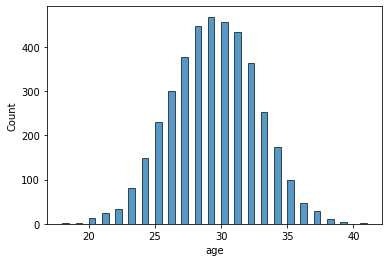

In [9]:
# возраст
sns.histplot(data=data, x="age");

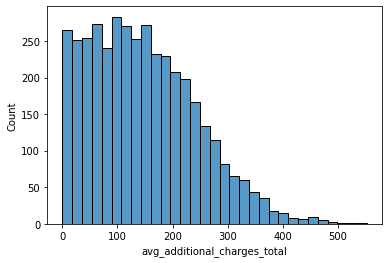

In [10]:
# суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон
sns.histplot(data=data, x="avg_additional_charges_total");

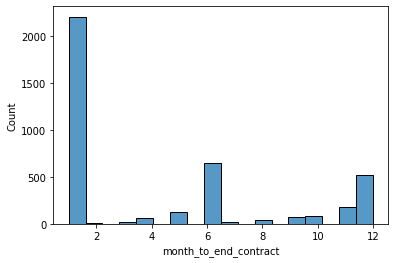

In [11]:
# срок до окончания текущего действующего абонемента (в месяцах)
sns.histplot(data=data, x="month_to_end_contract");

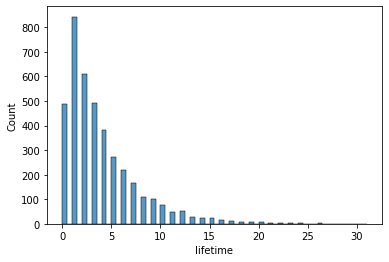

In [12]:
# время с момента первого обращения в фитнес-центр (в месяцах)
sns.histplot(data=data, x="lifetime");

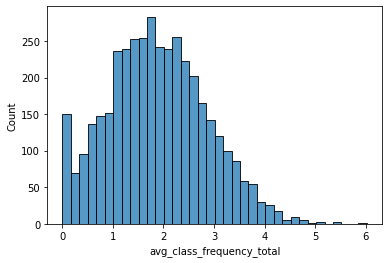

In [13]:
# средняя частота посещений в неделю за все время с начала действия абонемента
sns.histplot(data=data, x="avg_class_frequency_total");

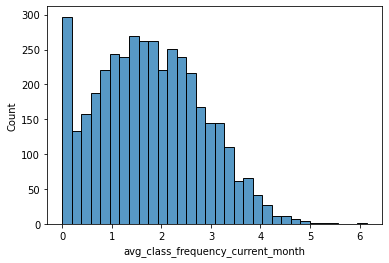

In [14]:
# средняя частота посещений в неделю за предыдущий месяц
sns.histplot(data=data, x="avg_class_frequency_current_month");

In [15]:
#проверим датасет на дубликаты
data.duplicated().sum()

0

- Датасет состоит из 14 колонок и 4000 строк.
- Привели названия столбцов к единому регистру.
- Поменяли тип переменной в столбце month_to_end_contract на целочисленный.
- Округлили числовые значения до сотых.
- Пропусков в данных нет.
- Дубликатов нет.

## Шаг 2. Проведем исследовательский анализ данных (EDA)

- Посмотрим на датасет: есть ли в нем отсутствующие признаки, изучим средние значения и стандартные отклонения

In [16]:
data.describe()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


- Распределение по полу практически 50/50.
- 85% клиентов проживают или работают в районе, где находится фитнес-центр.
- 49% клиентов являются сотрудниками компании-партнёра клуба.
- 31% клиентов использовали промо-код от знакомого при оплате первого абонемента.
- у 90% клиентов присутствует контактный телефон.
- Средняя длительность текущего действующего абонемента - 4.68 месяцев. Больше половины контрактов длительностью 1 месяц.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиента 29 лет.
- Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е.
- Средний срок до окончания текущего действующего абонемента - 4.32 месяца. Большинство контрактов заканчиваются через 1 месяц.
- Среднее время с момента первого обращения в фитнес-центр - 3.72 месяца. Для большинства клиентов это 1 месяц.
- Средняя частота посещений в неделю за все время с начала действия абонемента 1.88.
- Средняя частота посещений в неделю за предыдущий месяц 1.77. Т.е. в среднем клиенты ходят в фитнес-центр 2 раза в неделю.
- Доля оттока клиентов в среднем 27%.

- Посмотрим на средние значения признаков в двух группах — тех, кто ушел в отток и тех, кто остался

In [17]:
data.groupby('churn').mean().T

churn,0,1
gender,0.51,0.51
near_location,0.87,0.77
partner,0.53,0.36
promo_friends,0.35,0.18
phone,0.90,0.90
contract_period,5.75,1.73
group_visits,0.46,0.27
age,29.98,26.99
avg_additional_charges_total,158.45,115.08
month_to_end_contract,5.28,1.66


- Распределение по полу не отличается.
- Ближе живущие или работающие клиенты реже попадают в отток.
- Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб.
- Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят в отток.
- Наличие мобильного номера клиента не отличается в группах
- Средняя длительность договора больше у оставшихся пользователей, у большей части клиентов в оттоке срок договора составляет 1 месяц.
- Оставшиеся пользователи чаще ходят на групповые занятия.
- Разница в среднем возрасте небольшая.
- Выручка от других услуг фитнес-центра выше у оставшихся клиентов.
- Оставшееся время до окончания срока действия договора больше у оставшихся клиентов.
- Средняя частота посещений в неделю за все время и за предыдущий месяц у оставшихся клиентов больше в 2 раза.

- Построим столбчатые гистограммы и распределения признаков для тех, кто ушёл (отток) и тех, кто остался (не попали в отток)

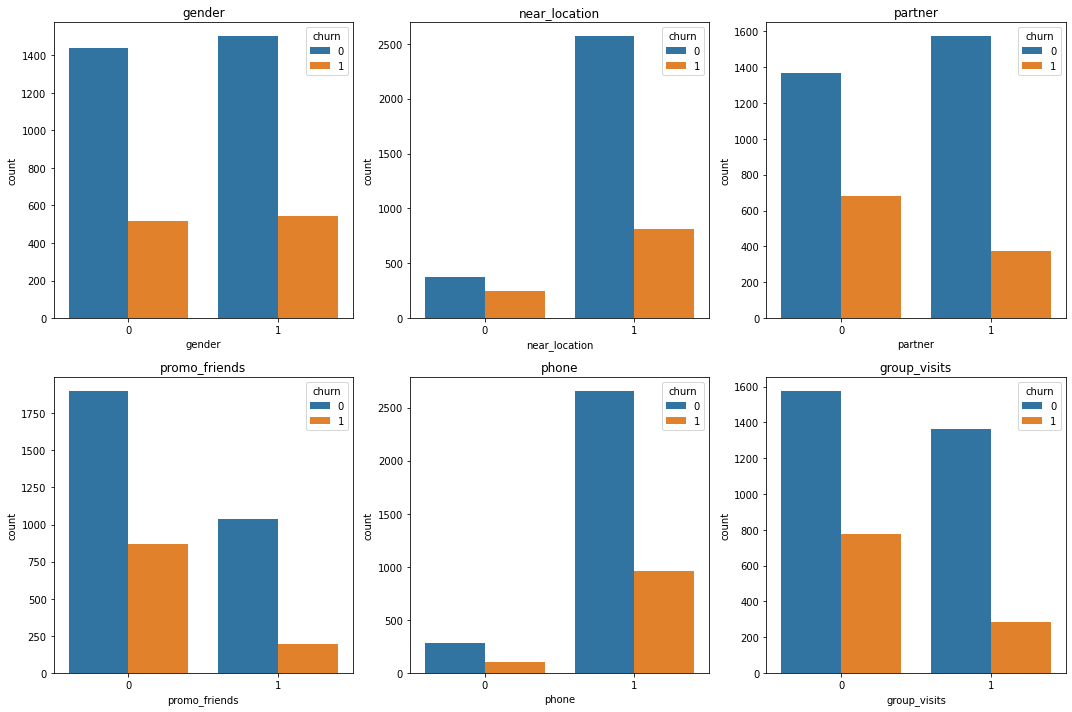

In [18]:
# сначала посмотррим на распределения для бинарных признаков
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

a = 2
b = 3
c = 1

fig = plt.figure(figsize=(15,10))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.countplot(data=data, x=data[i], hue='churn')
    c = c + 1

plt.tight_layout()
plt.show()

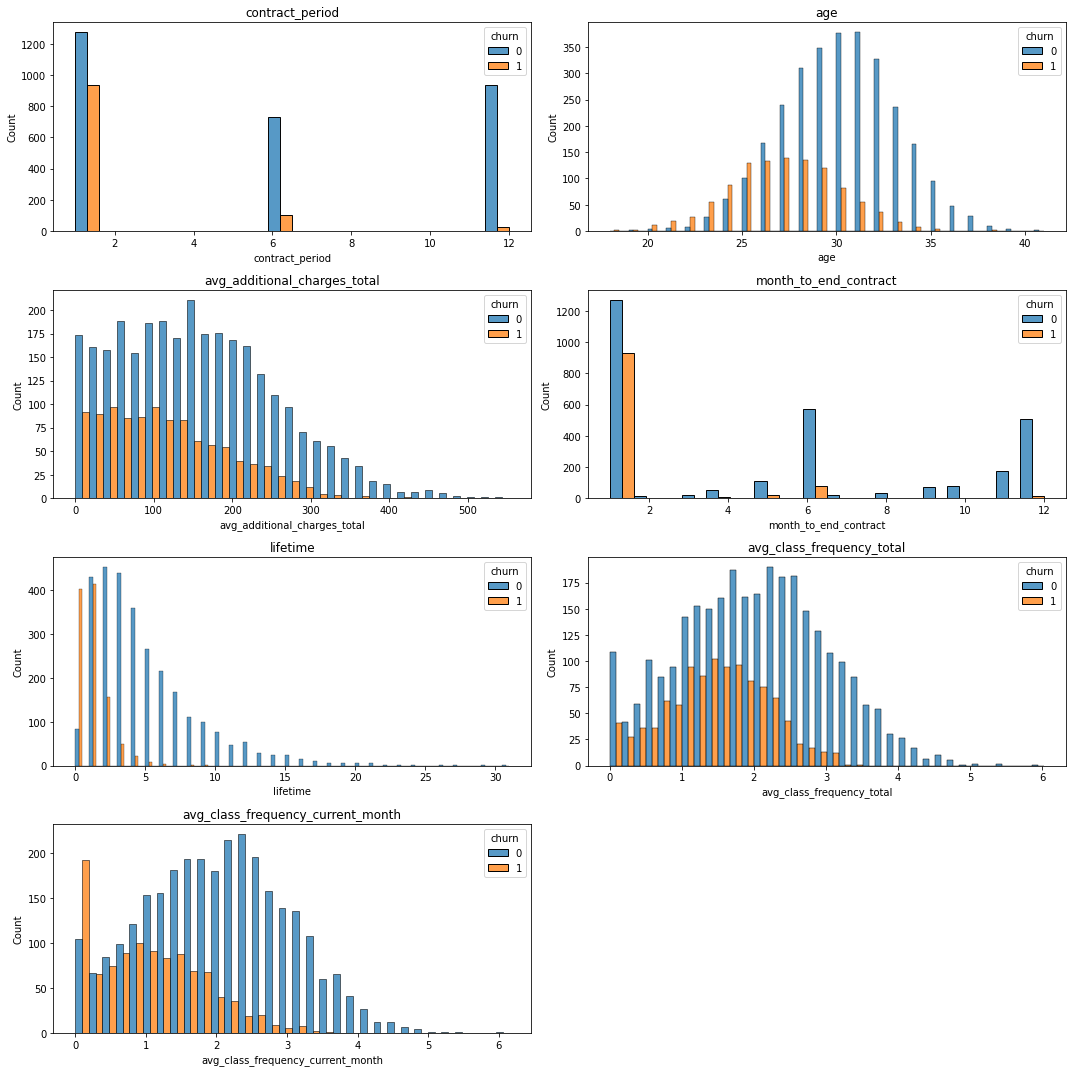

In [19]:
columns = ['contract_period',
           'age',
           'avg_additional_charges_total',
           'month_to_end_contract',
           'lifetime',
           'avg_class_frequency_total',
           'avg_class_frequency_current_month']

a = 4
b = 2
c = 1

fig = plt.figure(figsize=(15,15))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.histplot(x = data[i],
                hue='churn',
                data=data,
                multiple='dodge')
    c = c + 1

plt.tight_layout()
plt.show()

- Построим матрицу корреляций и отобразим её

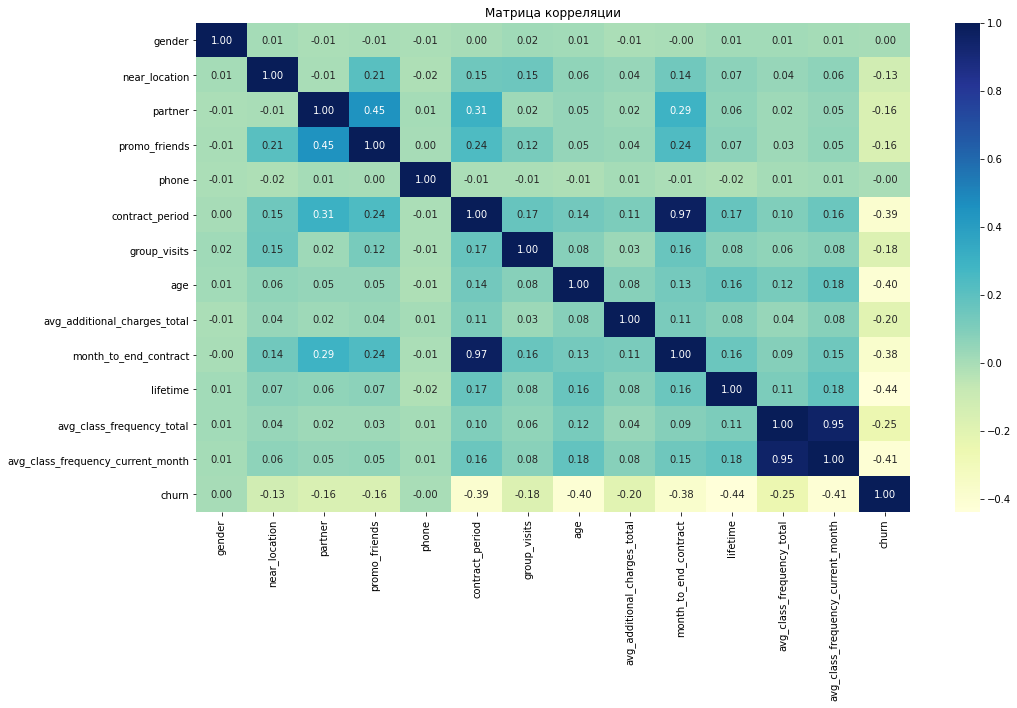

In [20]:
cm = data.corr()
plt.figure(figsize=(16,9))
sns.heatmap(cm, annot=True, fmt = '0.2f', cmap="YlGnBu")
plt.title('Матрица корреляции')
plt.show();

- Явной зависимости факта оттока от признаков не обнаружено.
- Судя по матрице корреляций, есть две пары скоррелированных признаков: month_to_end_contract и contract_period, avg_class_frequency_total и avg_class_frequency_current_month. Удалим их.

## Шаг 3. Постройте модель прогнозирования оттока клиентов

Построим модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце:

- Разбьем данные на обучающую и валидационную выборку функцией train_test_split().
- Обучим модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.
- Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке. Сравним по ним модели.

In [21]:
# разделим наши данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1)
y = data['churn']

# разделяем модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# обучаем StandartScaler на обучающей выборке
scaler = StandardScaler()
scaler.fit(X_train)

# Преобразуем обучающий и валидационные наборы данных
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [22]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title='Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))

# зададим алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0, solver='liblinear')
# обучим модель
lr_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:',
)


# зададим алгоритм для новой модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(n_estimators = 100, random_state = 0) # Ваш код здесь
# обучим модель случайного леса
rf_model.fit(X_train_st, y_train)
# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]
# выведем все метрики
print_all_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83


- По всем показателям модель логической регрессии показала себя лучше.

## Шаг 4. Сделайте кластеризацию клиентов

- Стандартизируем данные.
- Построим матрицу расстояний функцией linkage() на стандартизованной матрице признаков и нарисуем дендрограмму.

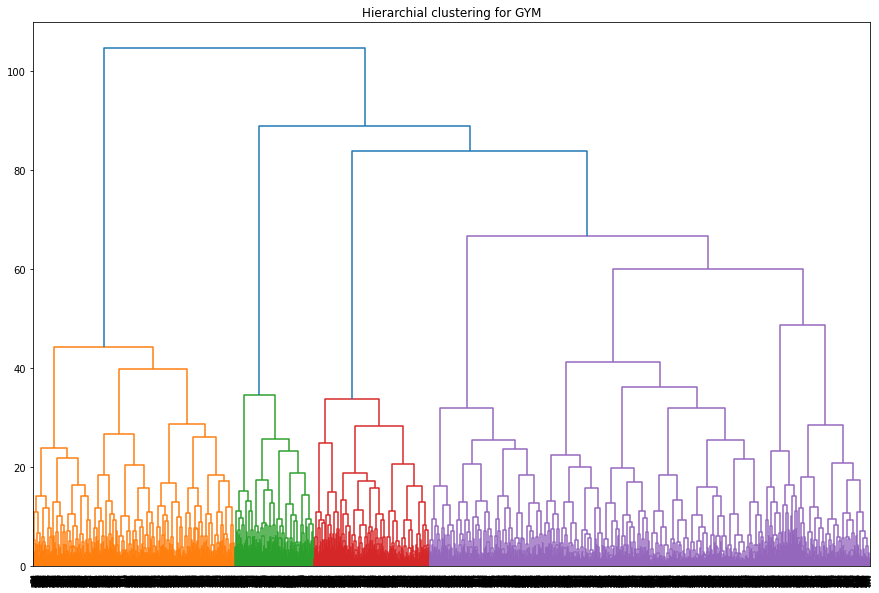

In [23]:
scaler = StandardScaler() # создаём объект класса scaler (нормализатор)
X_sc = scaler.fit_transform(X) # обучаем нормализатор и преобразуем набор данных

linked = linkage(X_sc, method = 'ward')

plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Hierarchial clustering for GYM')
plt.show()

- Явно выделены 4 кластера.
- Мы использует 5 по ТЗ.

- Обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов

In [24]:
# задаём модель k_means с числом кластеров 5 и фиксируем значение random_state
km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений (алгоритм присваивает им номера от 0 до 2)
labels = km.fit_predict(X_sc)

- Посмотрим на средние значения признаков для кластеров. Можно ли сразу что-то заметить?

In [25]:
# сохраняем метки кластера в поле нашего датасета
data['cluster_km'] = labels
 
# выводим статистику по средним значениям нафших признаков по кластеру
data.groupby(['cluster_km']).mean().T.style.background_gradient(cmap='coolwarm', axis=1).set_precision(2)

cluster_km,0,1,2,3,4
gender,0.50,0.52,0.50,0.49,0.56
near_location,0.96,0.86,0.00,1.00,0.98
partner,0.78,0.47,0.46,0.35,0.36
promo_friends,0.57,0.31,0.08,0.24,0.23
phone,1.00,0.00,1.00,1.00,1.00
contract_period,10.89,4.79,2.35,1.95,2.67
group_visits,0.54,0.43,0.22,0.34,0.47
age,29.98,29.30,28.48,28.17,30.13
avg_additional_charges_total,160.76,143.96,135.46,131.62,161.66
month_to_end_contract,9.95,4.48,2.20,1.86,2.46


In [26]:
# посмотрим, сколько примеров в кластерах
data.groupby(['cluster_km'])['gender'].count()

cluster_km
0    1010
1     385
2     505
3    1262
4     838
Name: gender, dtype: int64

- Кластеры 0 и 3 - самые многочисленные.
- Кластеры 1 и 2 напротив - самые малочисленные.

- Кластеры 0 и 4 с самым низким оттоком.
- У этих кластеров также:
    - самая высокая средняя суммарная выручка от других услуг фитнес-центра;
    - самое высокое среднее время с момента первого обращения в фитнес-центр;
    - самый высокий процент посещения групповых занятий;
    - самая высокая средняя частота посещений в неделю за все время и за предыдущий месяц.
- Клиенты из кластера 0:
    - чаще являются сотрудниками компании-партнёра клуба;
    - чаще являются участниками акции «приведи друга»;
    - у них самый длительный текущий действующий абонемент;
    - самый большой срок до окончания текущего действующего абонемента.
- Кластеры 2 и 3 с самым высоким оттоком.
- У этих кластеров также:
    - самая низкая средняя суммарная выручка от других услуг фитнес-центра;
    - самое маленькое среднее время с момента первого обращения в фитнес-центр;
    - самая низкая средняя частота посещений в неделю за все время и за предыдущий месяц.

- Построим распределения признаков для кластеров. Можно ли что-то заметить по ним?

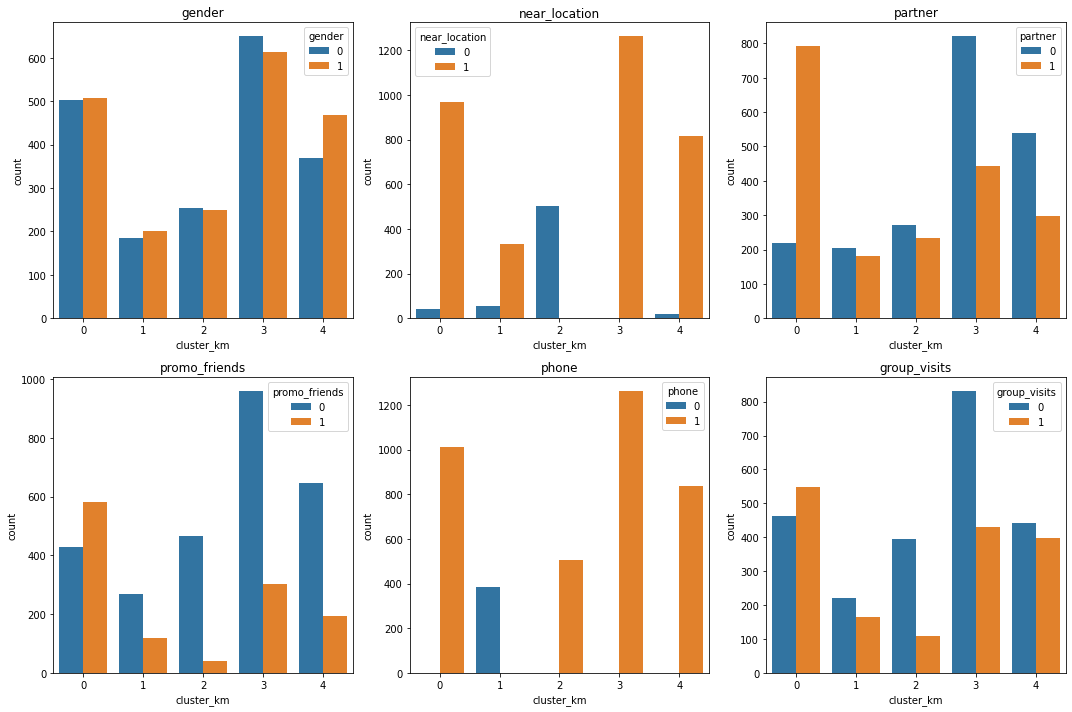

In [27]:
# построим countplot-графики для бинарных признаков
columns = ['gender', 'near_location', 'partner', 'promo_friends', 'phone', 'group_visits']

a = 2
b = 3
c = 1

fig = plt.figure(figsize=(15,10))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.countplot(data=data, x='cluster_km', hue=data[i])
    c = c + 1

plt.tight_layout()
plt.show()

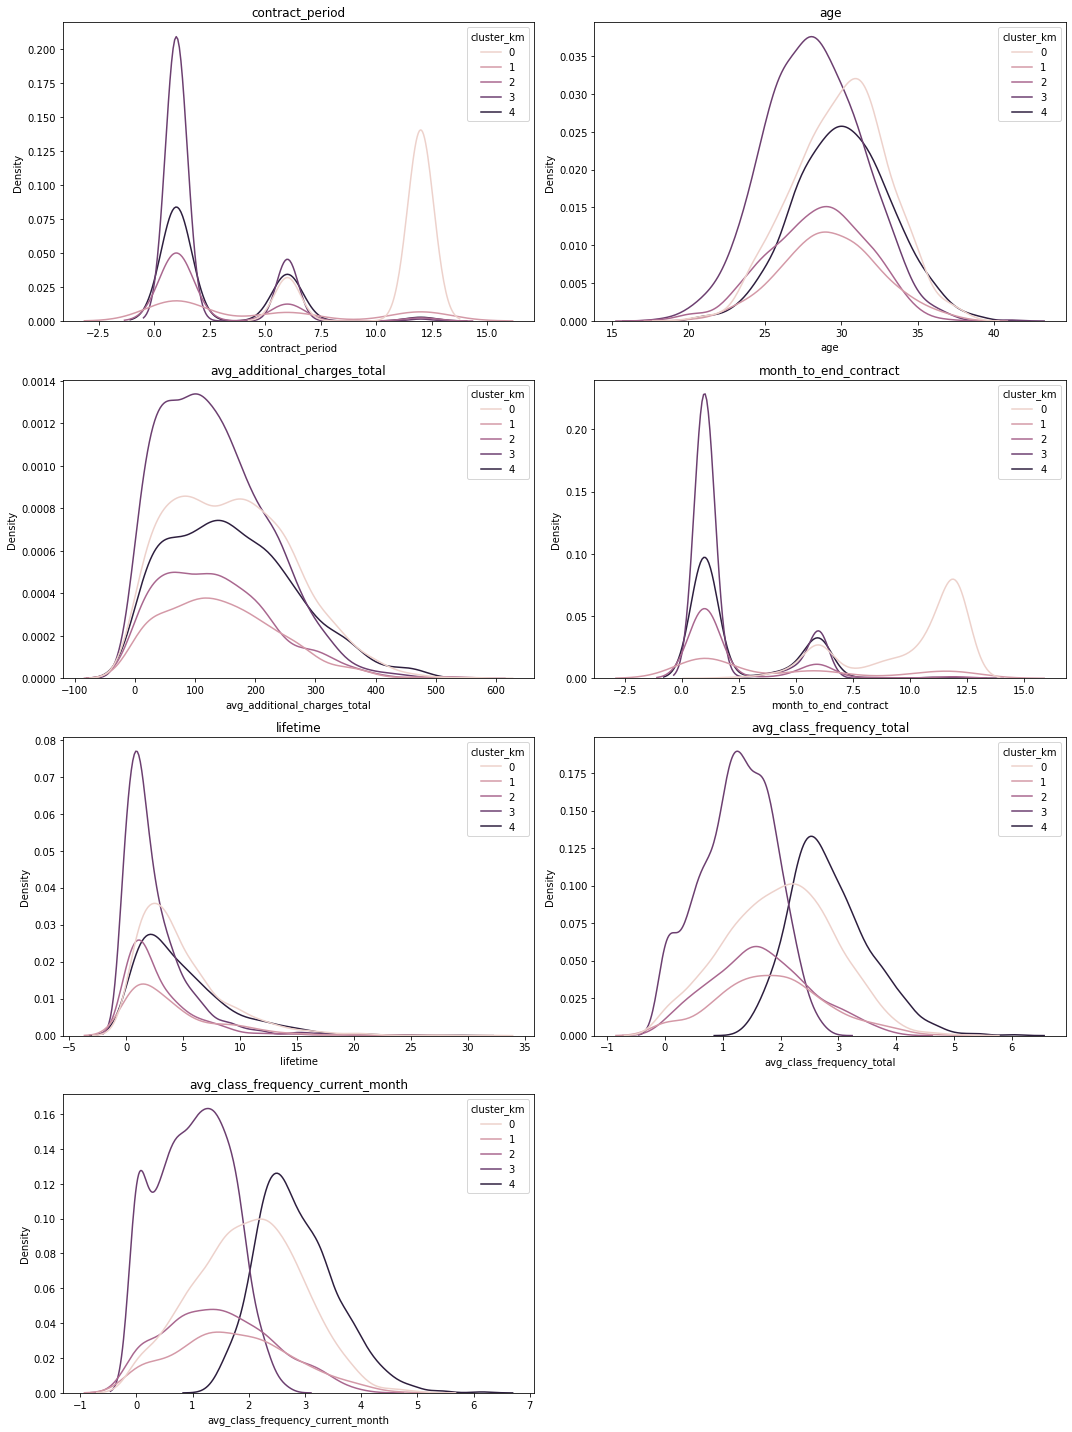

In [28]:
# построим kdeplot-графики для небинарных признаков
columns = ['contract_period',
           'age',
           'avg_additional_charges_total',
           'month_to_end_contract',
           'lifetime',
           'avg_class_frequency_total',
           'avg_class_frequency_current_month']

a = 4
b = 2
c = 1

fig = plt.figure(figsize=(15,20))

for i in columns:
    plt.subplot(a, b, c)
    plt.title(i)
    plt.xlabel(i)
    sns.kdeplot(x = data[i],
                hue='cluster_km',
                data=data)
    c = c + 1

plt.tight_layout()
plt.show()

- Распределения подтверждают сделанные ранее выводы.

- Для каждого полученного кластера посчитаем долю оттока (методом groupby()). Отличаются ли они по доле оттока? Какие кластеры склонны к оттоку, а какие — надёжны?

In [29]:
data.groupby('cluster_km').agg({'churn':'mean'}).sort_values(by='churn')

,churn
cluster_km,
0,0.03
4,0.07
1,0.27
2,0.44
3,0.51


- Кластеры 0 и 4 с самым низким оттоком.
- Кластеры 2 и 3 с самым высоким оттоком.

## Шаг 5. Сформулируем выводы и предложим базовые рекомендации по работе с клиентами

Выводы по имеющимся данным:

- Распределение по полу практически 50/50.
- 85% клиентов проживают или работают в районе, где находится фитнес-центр.
- 49% клиентов являются сотрудниками компании-партнёра клуба.
- 31% клиентов использовали промо-код от знакомого при оплате первого абонемента.
- у 90% клиентов присутствует контактный телефон.
- Средняя длительность текущего действующего абонемента - 4.68 месяцев. Больше половины контрактов длительностью 1 месяц.
- 41% клиентов посещают групповые занятия.
- Средний возраст клиента 29 лет.
- Средняя суммарная выручка от других услуг фитнес-центра - 147 у.е.
- Средний срок до окончания текущего действующего абонемента - 4.32 месяца. Большинство контрактов заканчиваются через 1 месяц.
- Среднее время с момента первого обращения в фитнес-центр - 3.72 месяца. Для большинства клиентов это 1 месяц.
- Средняя частота посещений в неделю за все время с начала действия абонемента 1.88.
- Средняя частота посещений в неделю за предыдущий месяц 1.77. Т.е. в среднем клиенты ходят в фитнес-центр 2 раза в неделю.
- Доля оттока клиентов в среднем 27%.

Выводы на основе отличий признаков у клиентов, попавших в отток и оставшихся:

- Распределение по полу не отличается.
- Ближе живущие или работающие клиенты реже попадают в отток.
- Сотрудники компаний-партнеров реже перестают посещать фитнесс-клуб.
- Клиенты, пришедшие по акции "Приведи друга" в два раза реже уходят в отток.
- Наличие мобильного номера клиента не отличается в группах
- Средняя длительность договора больше у оставшихся пользователей, у большей части клиентов в оттоке срок договора составляет 1 месяц.
- Оставшиеся пользователи чаще ходят на групповые занятия.
- Разница в среднем возрасте небольшая.
- Выручка от других услуг фитнес-центра выше у оставшихся клиентов.
- Оставшееся время до окончания срока действия договора больше у оставшихся клиентов.
- Средняя частота посещений в неделю за все время и за предыдущий месяц у оставшихся клиентов больше в 2 раза.

Матрица корреляции показала, что:

- Явной зависимости факта оттока от признаков не обнаружено.
- Есть две пары скоррелированных признаков: month_to_end_contract и contract_period, avg_class_frequency_total и avg_class_frequency_current_month.

Далее была построена модель бинарной классификации клиентов, где целевой признак — факт оттока клиента в следующем месяце.

Обучили модель на train-выборке двумя способами:
    - логистической регрессией,
    - случайным лесом.

Оценили метрики accuracy, precision и recall для обеих моделей на валидационной выборке и пришли к выводу, что по всем показателям модель логической регрессии показала себя лучше.

Сделали кластеризацию клиентов:

- Кластеры 0 и 4 с самым низким оттоком.
- У этих кластеров также:
    - самая высокая средняя суммарная выручка от других услуг фитнес-центра;
    - самое высокое среднее время с момента первого обращения в фитнес-центр;
    - самый высокий процент посещения групповых занятий;
    - самая высокая средняя частота посещений в неделю за все время и за предыдущий месяц.
- Клиенты из кластера 0:
    - чаще являются сотрудниками компании-партнёра клуба;
    - чаще являются участниками акции «приведи друга»;
    - у них самый длительный текущий действующий абонемент;
    - самый большой срок до окончания текущего действующего абонемента.
- Кластеры 2 и 3 с самым высоким оттоком.
- У этих кластеров также:
    - самая низкая средняя суммарная выручка от других услуг фитнес-центра;
    - самое маленькое среднее время с момента первого обращения в фитнес-центр;
    - самая низкая средняя частота посещений в неделю за все время и за предыдущий месяц.
    
Основные выводы:

У нас нарисовался портрет идеального среднестатистического клиента фитнес-центра:

- Это мужчина или женщина в среднем 30 лет.
- Проживает или работает в районе, где находится фитнес-центр.
- Является сотрудником компании-партнёра клуба или пришел в рамках акции «приведи друга».
- Заключает абонемент минимум на 6 мес.
- Посещает групповые занятия.
- Пользуется дополнительными услугами фитнес-центра.
- В среднем посещает фитнес-центр 2-3 раза в неделю.

В отток часто попадают клиенты, которые:

- живут или работают далеко от фитнес-центра;
- не являются сотрудниками компании-партнёра клуба или не участвовали в акции «приведи друга»;
- заключают абонемент на срок 1 месяц;
- редко посещаю групповые занятия;
- редко пользуются дополнительными услугами фитнес-центра;
- в среднем посещают фитнес-центр 1 раз в неделю.

Рекомендации:

- Завлекать клиентов, предлагая партнерские программы и промо-акции.
- Завлекать клиентов, предлагая более выгодные цены на абонементы на 6-12 месяцев.
- Реклама групповых занятий и дополнительных услуг фитне-центра.